In [11]:
!pip install getenv
!pip install psycopg2
!pip install geoalchemy2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
# import the required packages
import pandas as pd
import geopandas as gpd
import getenv
import os
import psycopg2
import pandas as pd
import sqlalchemy
from shapely import wkt
import geoalchemy2
from ast import literal_eval # for unstring the string, e.g., '[1,2]' to [1,2]
import numpy as np
import math
import fiona

In [13]:
pd.set_option('display.max_columns', None)

### Modulation

this part of the analysis takes into account the first map with soil quality indices (notes), and checks whether or not the notes must be modified in the function of their surrounding environment or the additional soil layers (UNITE Carto and VITICOL), and also the slope.

so we use the layer "notes_layer", and we modify the notes taking into account the modulation table and the priority of modifying the notes. Here are layers where their notes will be modified:

1) a buffer of 3m around buildings 

2) a buffer of 3m around roads

3) a buffer of 10m around railways

4) the polygon intersecting with the layer soil unite carto and unite viticol

5) the slope

#### Modulation rules

Aprat from that there are some rules to apply the modulation:

1) if a polygon has intersection with two or more buffer zones, the modulation will be accumulated

2) besides the buffer layers where we always apply the modulation, the priority of other three layers for applying modulation is:

first: UNITE VITICOLE

second: UNITE CARTO

third: SLOPE

3) the notes for each soil quality index should not go below 1 or bigger than 6

##### Unite Carto

1) attribute "PROF_PHYSIOLOGIQUE_TXT" has priority over "PIERROSITE_TXT"

2) attribute "REGIME_HYDRIQUE_TXT" has priority over "TEXTURE_TXT"


##### Unite viticol

1) attribute "PROF_ENRACINEMENT_TXT" has priority over "HYDROMORPHIE_TXT"

In [17]:
conn = psycopg2.connect(
    host='datasource.regionmorges.ch',
    database='',
    user='',
    password='',
    options='')

In [18]:
conn2 = psycopg2.connect(
    host='datasource.regionmorges.ch',
    database='',
    user='',
    password='',
    options='')

In [19]:
# read table notes
sql = "SELECT * FROM iqs_notes_layer_v2"
notes_layer = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')

#### slope attribute in notes table

we have to add slope_mean as percentage (degree to percentage) and then based on the percentage ranges, define the attribute values as in the modulation table


In [20]:
for i, row in notes_layer.iterrows():
    slope_percent = np.round(np.tan(math.radians(row['slope_mean'])) * 100)
    if slope_percent<=5:
        notes_layer.at[i, 'slope_attribute'] = '< 5%'
    elif (slope_percent>5 and slope_percent <=10):
        notes_layer.at[i, 'slope_attribute'] = 'entre 5 et 10%'
    elif (slope_percent>10 and slope_percent <=15):
        notes_layer.at[i, 'slope_attribute'] = 'entre 10 et 15% compris'
    elif (slope_percent>15 and slope_percent <=18):
        notes_layer.at[i, 'slope_attribute'] = 'entre 15 et 18% compris'
    elif (slope_percent>18 and slope_percent <=30):
        notes_layer.at[i, 'slope_attribute'] = 'entre 18% et 30'
    elif slope_percent>30:
        notes_layer.at[i, 'slope_attribute'] = '> 30 %'
    

In [21]:
notes_layer['slope_attribute'].unique()

array(['< 5%', 'entre 5 et 10%', 'entre 10 et 15% compris',
       'entre 18% et 30', '> 30 %', 'entre 15 et 18% compris'],
      dtype=object)

In [22]:
# in this part we assign the layer id to the notes layer with the following definition:

# layer id 9 : the buffer 10m around the chemin de fer
# layer id 10: the buffer 3m around the chemin
# layer if 11: the buffer 3m around the batiment

# here I create a list of layer_ids for the three layers of three buffers
# when the polygon consists of building buffer and the road/railway buffer, then the modulation will be accumulated

for i, row in notes_layer.iterrows():
    list_layer_id=[]
    if row['buffer_dur']=='route, chemin':
        if (row['buffer_bat']==None and row['buffer_bat_sout']==None):
            list_layer_id=[10]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
        else:
            list_layer_id=[10,11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
    elif row['buffer_dur']=='chemin de fer':
        if (row['buffer_bat']==None and row['buffer_bat_sout']==None):
            list_layer_id=[9]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
        else:
            list_layer_id=[9,11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
    elif (row['buffer_bat']!=None or row['buffer_bat_sout']!=None):
        if row['buffer_dur']==None:
            list_layer_id=[11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)

In [23]:
 # convert all NaN to None in the notes_layer table
notes_layer = notes_layer.replace(np.nan, None)

In [73]:
# fix soil layer attributes
notes_layer = notes_layer.replace('100 ? 180 cm', '100 – 180 cm')

In [74]:
notes_layer = notes_layer.replace('70 ? 100 cm', '70 – 100 cm')

### Start Modulation 

In [26]:
# read the modulation table from the db
# we filter the modulation table to exclude the id_couche=14 since this layer is Null and it is used for another part of the
# project which is the adjustment tool

query = """select * from modulation where id_couche !=14"""
modulation = pd.read_sql(query, conn2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [27]:
# read the table attribut from the db
query = """select * from attribut"""
attribute = pd.read_sql(query, conn2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [28]:
# merge attribute table and modualtion to get the attributes names in the modulation table
modulation = modulation.join(attribute.set_index('id_attribut'), on='id_attribut')

In [29]:
modulation

,id_modulation,id_couche,id_attribut,valeur,ordre_de_priorite,comment,perm_note_pourc,perm_fiab_pourc,prof_note_pourc,prof_note_abs,prof_fiab_pourc,prof_fiab_abs,poro_note_pourc,poro_fiab_pourc,mo_a_note_abs,mo_a_fiab_abs,ph_note_abs,ph_fiab_abs,pollution_message,mo_a_fiab_pourc,mo_a_note_pourc,poro_note_abs,poro_fiab_abs,attribut
0,110,15,16,Excès d'eau temporaire visible à une profondeu...,None,None,NaN,NaN,-40.0,NaN,20.0,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,HYDROMORPHIE_TXT
1,3,12,2,< 5%,None,None,NaN,NaN,0.0,NaN,20.0,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,pente ( calculer moyenne par polygone)
2,50,13,7,Limono-sableux à silto-limoneux (lsul),None,None,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,TEXTURE_TXT
3,38,13,6,Moraine rhodanienne de fond compact,None,None,NaN,NaN,NaN,NaN,NaN,NaN,-20.0,20.0,None,None,NaN,NaN,None,NaN,NaN,None,None,ROCHE_MERE_SUP_TXT
4,105,15,15,50 -70 cm,"""profondeur enracinement txt"" est prioritaire ...",None,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,PROF_ENRACINEMENT_TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,10,13,3,Assez superficiel (30-50 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,PROF_PHYSIOLOGIQUE_TXT
77,11,13,3,Moyennement profond (50-70 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,PROF_PHYSIOLOGIQUE_TXT
78,13,13,3,Très profond (>100 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,NaN,NaN,NaN,6.0,NaN,5.0,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,None,None,PROF_PHYSIOLOGIQUE_TXT
79,119,13,6,Moraine rhodanienne sableuse,None,None,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0,None,None,NaN,NaN,None,NaN,NaN,None,None,ROCHE_MERE_SUP_TXT


In [30]:
# convert all NaN to None in the modualtion table
modulation = modulation.replace(np.nan, None)

#### Steps to pereform modulation

1) take a row from the notes_layer 

2) check if the row includes buffer by checking the buff_layer column in notes_layer

3) if there is buffer check if the buffer includes only a layer or if it's an overlap of two buffers

4) if overlap of two buffers then sum the modulation values ( for example, a polygon is an overlap of building buffer and road buffer, and the perm_note for building_buffer (-50%) and the perm_note for road buffer (-50%) will multiply together and thus will be 0.5*0.5 = 0.25 >> so the new perm_note = old_perm_note + 0.25. So if the initial perm_notes was 6, then the modulated one will be 1.5

5) then we check soil priority >> viticol > carto > slope

6) then we check the layer priority if soil pr is either carto or viticol

7) we check the value >> if lowr than 1 >> then set as one and if bigger than 6 then set as 6

In [31]:
# a function to merge columns of abs and pourc in one single columns
def merge_col(df, old_col_1, old_col_2, new_col):
    for i, row in df.iterrows():
        if (row[old_col_1]!=None and row[old_col_2]==None):
            df.at[i, new_col] = row[old_col_1]
        elif (row[old_col_1]==None and row[old_col_2]!=None):
            df.at[i, new_col] = row[old_col_2]
        else:
            df.at[i, new_col] = None
    return df

In [32]:
modulation = merge_col(modulation, 'prof_note_pourc', 'prof_note_abs', 'prof_note')

In [33]:
modulation = merge_col(modulation, 'prof_fiab_pourc', 'prof_fiab_abs', 'prof_fiab')

In [34]:
modulation = merge_col(modulation, 'poro_note_pourc', 'poro_note_abs', 'poro_note')

In [35]:
modulation = merge_col(modulation, 'poro_fiab_pourc', 'poro_fiab_abs', 'poro_fiab')

In [36]:
modulation = merge_col(modulation, 'mo_a_note_pourc', 'mo_a_note_abs', 'mo_a_note')

In [37]:
modulation = merge_col(modulation, 'mo_a_fiab_pourc', 'mo_a_fiab_abs', 'mo_a_fiab')

In [38]:
modulation = modulation.drop(columns=['prof_note_pourc', 'prof_note_abs', 'prof_fiab_pourc', 'prof_fiab_abs',
       'poro_note_pourc', 'poro_fiab_pourc', 'mo_a_note_abs', 'mo_a_fiab_abs', 'mo_a_fiab_pourc',
       'mo_a_note_pourc', 'poro_note_abs', 'poro_fiab_abs'])

In [39]:
modulation.columns = ['id_modulation', 'id_couche', 'id_attribut', 'valeur',
       'ordre_de_priorite', 'comment', 'perm_note', 'perm_fiab',
       'ph_note', 'ph_fiab', 'pollution_message', 'attribut',
       'prof_note', 'prof_fiab', 'poro_note', 'poro_fiab', 'mo_a_note',
       'mo_a_fiab']

In [40]:
modulation

,id_modulation,id_couche,id_attribut,valeur,ordre_de_priorite,comment,perm_note,perm_fiab,ph_note,ph_fiab,pollution_message,attribut,prof_note,prof_fiab,poro_note,poro_fiab,mo_a_note,mo_a_fiab
0,110,15,16,Excès d'eau temporaire visible à une profondeu...,None,None,None,None,None,None,None,HYDROMORPHIE_TXT,-40.0,20.0,NaN,NaN,NaN,NaN
1,3,12,2,< 5%,None,None,None,None,None,None,None,pente ( calculer moyenne par polygone),0.0,20.0,NaN,NaN,NaN,NaN
2,50,13,7,Limono-sableux à silto-limoneux (lsul),None,None,10.0,20.0,None,None,None,TEXTURE_TXT,NaN,NaN,NaN,NaN,NaN,NaN
3,38,13,6,Moraine rhodanienne de fond compact,None,None,None,None,None,None,None,ROCHE_MERE_SUP_TXT,NaN,NaN,-20.0,20.0,NaN,NaN
4,105,15,15,50 -70 cm,"""profondeur enracinement txt"" est prioritaire ...",None,None,None,None,None,None,PROF_ENRACINEMENT_TXT,4.0,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,10,13,3,Assez superficiel (30-50 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,None,None,None,None,None,PROF_PHYSIOLOGIQUE_TXT,3.0,5.0,NaN,NaN,NaN,NaN
77,11,13,3,Moyennement profond (50-70 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,None,None,None,None,None,PROF_PHYSIOLOGIQUE_TXT,4.0,5.0,NaN,NaN,NaN,NaN
78,13,13,3,Très profond (>100 cm),"""prof_physiologique"" prioritaire sur ""pierrosi...",None,None,None,None,None,None,PROF_PHYSIOLOGIQUE_TXT,6.0,5.0,NaN,NaN,NaN,NaN
79,119,13,6,Moraine rhodanienne sableuse,None,None,None,None,None,None,None,ROCHE_MERE_SUP_TXT,NaN,NaN,20.0,20.0,NaN,NaN


In [41]:
# convert all NaN to None in the modualtion table
modulation = modulation.replace(np.nan, None)

In [42]:
# add soil priority to the modulation table

for i, row in modulation.iterrows():
    if row['id_couche']==15:
        modulation.at[i, 'priority_soil']=1
    elif row['id_couche']==13:
        modulation.at[i, 'priority_soil']=2
    elif row['id_couche']==12:
        modulation.at[i, 'priority_soil']=3
        

#### Modulation functions

There are 4 funtions that are defined bellow, but there are two principle functions, and two sub-functions

1) get_soil_modulation_val

1.1) unite_carto

1.2) unite_viticol

2) get_buff_modulation_val




In [81]:
# notes_row: the row in the base map (notes_layer) that we want to modulate the soil indices
# soil index: the index we want to modulate
# df: the modulation table
def unite_carto(df_filtered, priority, notes_row):
    df_p = df_filtered[df_filtered['priority_soil']==priority]
    attributes = df_p['attribut'].unique().tolist()
    if len(attributes)>1:
        if all(elem in attributes for elem in ['PROF_PHYSIOLOGIQUE_TXT', 'PIERROSITE_TXT']):
            val = notes_row['carto_prof_physiologique_txt']
        elif all(elem in attributes for elem in ['REGIME_HYDRIQUE_TXT', 'TEXTURE_TXT']):
            val = notes_row['carto_regime_hydrique_txt']
                
    else:
        val = notes_row['carto_'+attributes[0].lower()]
            ## if there is no value for carto then use slope
           
    if (val == None or val=='Non sondé' or val=='Non déterminé'):
        priority=3
        val = notes_row['slope_attribute']
    #print(val)
    return val

def unite_viticol(df_filtered, priority, notes_row):
    df_p = df_filtered[df_filtered['priority_soil']==priority]
    attributes = df_p['attribut'].unique().tolist()
    #print(attributes)
        
    if len(attributes) > 1:
        # attribute "PROF_ENRACINEMENT_TXT" has priority over "HYDROMORPHIE_TXT"
        val = notes_row['viticol_prof_enracinement_txt']
        #print(val)
    else:
        val = notes_row['viticol_'+attributes[0].lower()]
        ## test to see if code works , then I will optimize the code
    if val == None:
        #print("here")
        new_unique_pr = [n for n in df_filtered['priority_soil'].unique().tolist() if n != 1]
        priority = min(new_unique_pr)
        if priority == 2:
            val = unite_carto(df_filtered, priority, notes_row)
        else:
            val = notes_row['slope_attribute']
    #print(val)
    return val

def get_soil_modulation_val(df_mod, soil_index, notes_row):
    # filter the df for the three layers of carto, viticol , and slope
    df = df_mod[~df_mod['priority_soil'].isnull()]
    # filter the df for particlar soil_index where the values are not null
    df = df[~df[soil_index].isnull()]
    
    priority = min(df['priority_soil'].unique())
    #print(priority)
    #attributes = df['attribut'].unique()
    #print(attributes)
    if priority == 1:
        val = unite_viticol(df, priority, notes_row)
              
    elif priority == 2:
        val = unite_carto(df, priority, notes_row)
        
    else:
        val = notes_row['slope_attribute']
            
    
    soil_mod_prm = df_mod.loc[df_mod['valeur'] == val, soil_index].iloc[0] 
    if soil_mod_prm ==None:
        soil_mod_prm = 0
    
    return (soil_mod_prm,priority)

In [82]:
def get_buff_modulation_val(df,soil_index, notes_row):
    buff = literal_eval(notes_row['buff_layer'])
    if len(buff)==1:
        buff_mod_prm = df.loc[df['id_couche'] == buff[0], soil_index].iloc[0]
        if buff_mod_prm == None:
            buff_mod_prm = 0
        buff_mod_prm = 1 + buff_mod_prm/100
    else:
        buff_mod_prm_1 = df.loc[df['id_couche'] == buff[0], soil_index].iloc[0]
        buff_mod_prm_2 = df.loc[df['id_couche'] == buff[1], soil_index].iloc[0]
        if buff_mod_prm_1 == None:
            buff_mod_prm_1 = 0
        if buff_mod_prm_2 == None:
            buff_mod_prm_2 = 0
        buff_mod_prm = (1 + buff_mod_prm_1/100)*(1 + buff_mod_prm_2/100)
    
    return buff_mod_prm
        

In [83]:
# a copy of notes_layer and modualte the indices int he copied one
notes_modulated = notes_layer.copy()

In [ ]:
# now modulate the notes

# list of params to be modulated 
indices = ['perm_note', 'perm_fiab','prof_note','prof_fiab', 'poro_note', 'poro_fiab','mo_a_note', 'mo_a_fiab', 'ph_note', 'ph_fiab']

for i, row in notes_modulated.iterrows():
    if row['mod']:
    #print(i)
        for item in indices:
            #print(item)
            new_note = -1
            if row[item]!=None:
                soil_mod,priority = get_soil_modulation_val(modulation, item, row)
        
                if row['buff_layer']!=None:
                    buff_mod = get_buff_modulation_val(modulation, item, row)
        
                    if (soil_mod in range(1, 7, 1) and priority<3):
                        new_note = soil_mod * buff_mod
                    
                    else:
                        new_note = row[item]* (1 + soil_mod/100) * buff_mod
                else:
                    
                    if (soil_mod in range(1, 7, 1) and priority<3):
                        new_note = soil_mod
                        
                    else:
                        new_note = row[item]* (1 + soil_mod/100)
                    

                if new_note!= -1:
                    if new_note < 1:
                        new_note = 1
                    elif new_note > 6:
                        new_note = 6
    
                    notes_modulated.at[i,item] = round(new_note, 2)
        
        print(i,' :done')
            
        
    

In [85]:
notes_modulated_copy = notes_modulated.copy()

In [86]:
notes_modulated

,index,genre_entretien,groupe_entretien,type_surface_entretien,buffer_dur,buffer_bat,buffer_bat_sout,couv_s_design,batss_s_design,baths_s_design,dgav_geo_affect,paf_type_princ,paf_type_sec,paf_denom_com,paf_igt,paf_mixite,carto_prof_physiologique_txt,carto_regime_hydrique_txt,carto_pierrosite_txt,carto_texture_txt,carto_type_sol_txt,carto_matiere_organique_txt,carto_degres_acidite_txt,carto_roche_mere_sup_txt,viticol_fiche_unite,viticol_roche_mere_txt,viticol_type_sol_txt,viticol_prof_enracinement_txt,viticol_hydromorphie_txt,viticol_variantes_locales_txt,csdur_s_genre_txt,cseau_s_genre_txt,area,ndvi,revetement,slope_mean,geometry,building_type,ndvi_batiment,aff_num,couche_chemin,priority,id_n_1,id_n_2,id_n_3,id_n_4,perm_note,perm_fiab,perm_de_surf_comment_note,perm_de_surf_comment_fiab,prof_note,prof_fiab,poro_note,poro_fiab,poro_comment_note,poro_comment_fiab,mo_a_note,mo_a_fiab,mo_a_comment_note,mo_a_comment_fiab,mo_note,mo_fiab,mo_comment_note,mo_comment_fiab,ph_note,ph_fiab,ph_comment_note,ph_comment_fiab,pollution_note,pollution_fiab,pollution_comment_note,pollution_comment_fiab,mod,slope_attribute,buff_layer
0,0,None,None,None,None,habitation,None,couvert,None,None,None,Zone d'habitation de très faible densité,None,Zone d'habitation individuelle,None,non,Profond (70-100 cm),Modérément engorgés par l'eau,Non/peu pierreux,Silto-limoneux (ul),Sol brun,A mull,Faiblement acide (pH 5.9-6.7,Colluvions,None,None,None,None,None,None,None,None,0.823810,NaN,pas_vert,3.063302,"POLYGON ((2529341.275 1153745.277, 2529340.973...",None,None,NaN,True,2,14,1,1,1,1.0,4.0,pas de sol,None,1.00,4.00,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1,4,pas de sol,None,None,None,None,None,False,< 5%,[11]
1,1,None,None,None,None,None,None,couvert,None,None,None,Zone d'habitation de très faible densité,None,Zone d'habitations individuelles et familiales B,None,non,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,None,None,None,None,None,None,None,None,15.282842,NaN,pas_vert,2.517518,"POLYGON ((2530439.568 1151946.300, 2530439.500...",None,None,NaN,True,2,14,1,1,1,1.0,4.0,pas de sol,None,1.00,4.00,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1,4,pas de sol,None,None,None,None,None,False,< 5%,None
2,2,None,None,None,None,None,None,couvert,None,None,None,Zone d'habitation de très faible densité,None,Zone d'habitations individuelles et familiales B,None,non,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,None,None,None,None,None,None,None,None,15.157590,NaN,pas_vert,3.466726,"POLYGON ((2530398.640 1151958.500, 2530400.510...",None,None,NaN,True,2,14,1,1,1,1.0,4.0,pas de sol,None,1.00,4.00,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1,4,pas de sol,None,None,None,None,None,False,entre 5 et 10%,None
3,3,None,None,None,None,None,None,couvert,None,None,None,Zone d'habitation de très faible densité,None,Zone d'habitations individuelles et familiales B,None,non,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,None,None,None,None,None,None,None,None,4.573650,NaN,vert,5.448756,"POLYGON ((2530439.151 1151945.050, 2530436.022...",None,None,NaN,True,2,14,1,1,1,1.0,4.0,pas de sol,None,1.00,4.00,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1,4,pas de sol,None,None,None,None,None,False,entre 5 et 10%,None
4,4,None,None,None,None,None,None,couvert,None,None,None,Zone d'habitation de très faible densité,None,Zone d'habitations individuelles et familiales B,None,non,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,Non sondé,None,None,None,None,None,None,None,None,18.778934,NaN,pas_vert,2.385606,"POLYGON ((2530404.910 1151956.420, 2530401.765...",None,None,NaN,True,2,14,1,1,1,1.0,4.0,pas de sol,None,1.00,4.00,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1.0,4.0,pas de sol,None,1,4,pas de sol,None,None,None,None,None,False,< 5%,None
...,...,...,...,.

In [88]:
notes_modulated = notes_modulated.drop(columns=['priority', 'slope_mean', 'buff_layer'])

•	Fonction habitat NOTE =  0.2*ScorePermSurf +0.1*Score prof utile + 0.4* Scoreporosité + 0.3 *ScoreMO/A 
•	f(PU) = place 
•	f(porosité) = lieu de vie/place/ accès à l’eau à l’air
•	f(MO/A)= nourriture accessible
•	f(perméabilité de surface)= accès à l’eau
•	Fonction biomasse NOTE calcul 1 =(0.2*score(perméabilité de surface)+ 0.3 *score(PU) + 0.2*score(porosité) + 0.3*score(MO/A) + 0.2 ) faire le cacul puis le  pH vient moduler la note finale
•	Fonction biomasse NOTE calcul 2 =(0.1*score(perméabilité de surface)+ 0.2 *score(PU) + 0.1*score(porosité) + 0.2*score(MO/A) + 0.3pH ) 
•	2 calculs à tester pour le calcul de la biomasse car on veut voir les différences que cela fait
•	Note : La fonction évalue le potentiel de production naturel ( sans les intrants) : poten
•	PU = limite croissance racine
•	Porosité = conditionne la croissance des racines :  via l’ accès à l’eau, à l’air, capacité à explorer le milieu
•	pH = conditionne l’accessibilité des éléments nutritifs
•	MO/A = nourriture accessible
•	perméabilité de surface 


In [112]:
engine = sqlalchemy.create_engine('postgresql://******')
#print(bool(engine)) # <- just to keep track of the process


In [113]:
notes_modulated.to_postgis('notes_modulated_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

In [91]:
notes_module_func = notes_modulated.copy()

In [92]:
## apply functions on the modulated notes

for index, row in notes_module_func.iterrows():
    
    # funtion habitat
    
    notes_module_func.at[index, 'fonc_habitat_note'] = round(0.2*row['perm_note']+0.1*row['prof_note'] +0.4*row['poro_note'] + 0.3 *row['mo_a_note'], 2)
    notes_module_func.at[index, 'fonc_habitat_fiab'] = round(0.2*row['perm_fiab']+0.1*row['prof_fiab'] +0.4*row['poro_fiab'] + 0.3 *row['mo_a_fiab'], 2)
    
    # function production de biomasse calcul 1
    notes_module_func.at[index, 'fonc_biomass_note_calc1'] = round(0.2*row['perm_note']+0.2*row['prof_note'] +0.1*row['poro_note'] + 0.2 *row['mo_a_note'] + 0.3*row['ph_note'], 2)
    notes_module_func.at[index, 'fonc_biomass_fiab_calc1'] = round(0.2*row['perm_fiab']+0.2*row['prof_fiab'] +0.1*row['poro_fiab'] + 0.2 *row['mo_a_fiab'] + 0.3*row['ph_fiab'], 2)
    
    # function production de biomasse calcul 2
    fonc_bio_note_2 = 0.2*row['perm_note']+0.3*row['prof_note'] +0.2*row['poro_note'] + 0.3 *row['mo_a_note']
    fonc_bio_fiab_2 = 0.2*row['perm_fiab']+0.3*row['prof_fiab'] +0.2*row['poro_fiab'] + 0.3 *row['mo_a_fiab']
    
    if row['ph_note'] ==2:
        if (fonc_bio_note_2*0.8)<1:
            notes_module_func.at[index, 'fonc_biomass_note_calc2'] =1
        else:
            notes_module_func.at[index, 'fonc_biomass_note_calc2'] = round(fonc_bio_note_2 *0.8, 2)
            
        if (fonc_bio_fiab_2*1.2)>6:
            notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = 6
        else:
            notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = round(fonc_bio_fiab_2 *1.2, 2)
    else:
        notes_module_func.at[index, 'fonc_biomass_note_calc2'] = round(fonc_bio_note_2, 2)
        notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = round(fonc_bio_fiab_2, 2)
    
    # function rügulation de crues (döjä calculer dans le mandat 1)
    notes_module_func.at[index, 'fonc_rc_note'] = round(0.6*row['perm_note']+0.2*row['prof_note'] +0.2*row['poro_note'], 2)
    notes_module_func.at[index, 'fonc_rc_fiab'] = round(0.6*row['perm_fiab']+0.2*row['prof_fiab'] +0.2*row['poro_fiab'], 2)
    
    

In [114]:
engine = sqlalchemy.create_engine('postgresql://*******')
#print(bool(engine)) # <- just to keep track of the process

In [115]:
notes_module_func.to_postgis('notes_module_fonc_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

In [99]:
# read the site pollue

site_polluted = gpd.read_file("E:/Maryam/IQS/SitesPol_9982_QU5BK5/site_pollue_roi.shp")

#site_polluted = fiona.open("E:/Maryam/IQS/SitesPol_9982_QU5BK5/SitesPol_9982/SESA_SESA_TPR_SITE_POLLUE.shp")

<AxesSubplot:>

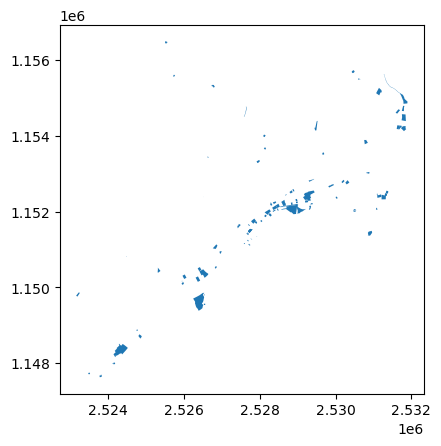

In [100]:
site_polluted.plot()

In [101]:
notes_module_func.columns

Index(['index', 'genre_entretien', 'groupe_entretien',
       'type_surface_entretien', 'buffer_dur', 'buffer_bat', 'buffer_bat_sout',
       'couv_s_design', 'batss_s_design', 'baths_s_design', 'dgav_geo_affect',
       'paf_type_princ', 'paf_type_sec', 'paf_denom_com', 'paf_igt',
       'paf_mixite', 'carto_prof_physiologique_txt',
       'carto_regime_hydrique_txt', 'carto_pierrosite_txt',
       'carto_texture_txt', 'carto_type_sol_txt',
       'carto_matiere_organique_txt', 'carto_degres_acidite_txt',
       'carto_roche_mere_sup_txt', 'viticol_fiche_unite',
       'viticol_roche_mere_txt', 'viticol_type_sol_txt',
       'viticol_prof_enracinement_txt', 'viticol_hydromorphie_txt',
       'viticol_variantes_locales_txt', 'csdur_s_genre_txt',
       'cseau_s_genre_txt', 'area', 'ndvi', 'revetement', 'geometry',
       'building_type', 'ndvi_batiment', 'aff_num', 'couche_chemin', 'id_n_1',
       'id_n_2', 'id_n_3', 'id_n_4', 'perm_note', 'perm_fiab',
       'perm_de_surf_comment_not

In [104]:
notes_module_func_pollue = notes_module_func.copy()

In [105]:
indices_to_update = []

for index, row in notes_module_func_pollue.iterrows():
    intersected = site_polluted['geometry'].intersects(row['geometry'])
    if intersected.any():
        indices_to_update.append(index)

notes_module_func_pollue.loc[indices_to_update, 'pollution_commentaire'] = 'attention cette zone intersecte un "site pollué" référez-vous à la loi et au cadastre des sites pollués avant toute action.'

print('done:', len(indices_to_update), 'rows updated')

done: 5554 rows updated


In [106]:
notes_module_func_pollue['pollution_commentaire'].unique()

array([nan,
       'attention cette zone intersecte un "site pollué" référez-vous à la loi et au cadastre des sites pollués avant toute action.'],
      dtype=object)

In [107]:
notes_module_func_pollue = notes_module_func_pollue.drop(columns=['pollution_note',
       'pollution_fiab', 'pollution_comment_note', 'pollution_comment_fiab'])

In [116]:
notes_module_func_pollue.to_postgis('notes_module_fonc_pollue_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

#### note 

when adding the geopandas df to postgis database, sometimes the data type of the column changes from float to text, the reason is that there are None values in the column, and thus the column type changes to text for the whole column. the solution here is to convert all None values in the flaot type columns to NaN and then add the table to postgis. 

another reason can be inconsistency in the data, if there are both whole numbers and also floats, then postgis tries to convert all column's data type to text.


In [13]:
modulated['perm_note'].unique()

array(['1', '1.5', '1.0', '3.0', '2.0', '2.5', '4.0', '1.25', '5.0',
       '6.0', '1.95', '2.7', '1.8', '3.9', '5.4', '3.25', '1.35', '4.8',
       '1.3', '2.6', '1.6', '4.5', '6', '1.2', '2.4', '3.2', '2.25',
       '3.6', '5.2', '1.12', '1.62'], dtype=object)